In [553]:
#default_exp ensemble

In [554]:
#hide
from nbdev.showdoc import *

# Dev comments

Project definitions:

- Set a method called dfit or overwrite fit method in order to have sklearn pipeline support?
- Delegates for an instance of estimator inside class or increment classes through factories (better support in sklearn pipelines)?


- [X] TODO: Solve Tree Predict mistery
- [ ] TODO: make gaussian process interface
- [ ] TODO: make meta bagged randomized prior class


- [X] TODO: make boosting and baging tree estimator classes
- [X] TODO: implement bagging and boosting meta estimator (include sampling from sub models)
- [X] TODO: include target scaling in pipeline
- [ ] TODO: make a "density" method, that returns a RandomVariable class
- [ ] TODO: Create DensityEstimator Base Class containing sample and density methods (density calls sample and returns RV CLASS)
- [ ] TODO: Mean, Variance and Entropy explainer tool (LIME, SHAP, foressts...)
- [X] TODO: Decide wether to allow multi output (doesnt model well multivariate bimodal joint probabilities, cheeky to sample (two different random samples))
- [ ] Implement KNN estimator
- [ ]

# Ensemble density estimators -

Density estimators based on ensemble methods, such as baging, boosting and some decision tree algorithms. All 'classes' are actually factories that dinamically extends the funcitonality of the original sklearn class with methods such as sample.

In [555]:
#export
from warnings import warn

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, normalize, QuantileTransformer, FunctionTransformer
from sklearn.multioutput import MultiOutputRegressor

try:
    from sparse_dot_topn import awesome_cossim_topn
except ImportError as e:
    warn(f"{e}")
    warn("sparse_dot_topn module not installed, will use naive dot product for vector query. This may lead to memory overload")
    

# Example data

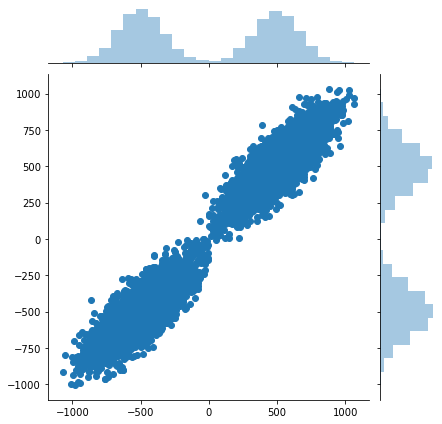

In [556]:
import seaborn as sns
from sklearn.datasets import make_regression

X,y = make_regression(
    n_samples=10000,
    n_features=15,
    n_informative=6,
    n_targets=2,
    bias=500,
    effective_rank=None,
    tail_strength=2,
    noise=0.2,
    shuffle=True,
    coef=False,
    random_state=None
)

bimodal_msk = np.random.randint(0,2,y.shape[0]).astype(bool)

y[bimodal_msk] = -abs(y[bimodal_msk])

sns.jointplot(y[:,0],y[:,1])

X_train, X_test = X[:8000], X[8000:]
y_train, y_test = y[:8000], y[8000:]

# Base Density Estimator

In [557]:
# export
from sklearn.base import BaseEstimator
class BaseDensityEstimator(BaseEstimator):
    @classmethod
    def load(self,path): pass 'load with dill'
    def save(self,path): pass 'save with dill'
    def sample(self, X, sample_size = None, weights = None): pass
    def _handle
        

SyntaxError: invalid syntax (<ipython-input-557-56d52b0ffb5f>, line 5)

# Usefull functions

In [558]:
#export
def pad_to_shape(array, shape):
    arr = np.zeros(shape)    
    arr[tuple(slice(0,i) for i in array.shape)] = array
    return arr

def cos_sim_query(query_vector, query_space, n_neighbors=50, lower_bound=0.0):    
    try:
        sim_matrix = (awesome_cossim_topn(normalize(query_vector), normalize(query_space).T,
                                         ntop=n_neighbors, lower_bound=lower_bound))     
    except NameError:
        sim_matrix = normalize(query_vector.dot(query_space.T))
        
    sim_matrix = sim_matrix.tocoo()
    idx = []
    sim = []
    arr_sizes = []
    for row in range(sim_matrix.shape[0]):
        s = sim_matrix.data[sim_matrix.row == row]
        i = sim_matrix.col[sim_matrix.row == row]
        sim.append(s)
        idx.append(i)
        arr_sizes.append(len(s))
    
    max_size = max(arr_sizes)
    idx = np.array([pad_to_shape(i, max_size) for i in idx]).astype(int)
    sim = np.array([pad_to_shape(s, max_size) for i in sim])
    if idx.shape[1] == 0:
        raise ValueError('No similarity greater than lower_bound found. Choose a lower threshold.')
    return  idx, sim

# MultiOutputRegressor (Move to skdensity.meta and fix sampling problem)

In [633]:
class CustomMultiOutputRegressor(MultiOutputRegressor):
    '''Custom multioutput for multioutput cases except random forests (which handles multi output directly)'''
    def apply(self,X):
        result = [estim.apply(X) for estim in self.estimators_]
        return np.concatenate(result, axis = -1)
    def sample(self, X, sample_size = 10, weights = None):        
        result = np.array([estim.sample(X, sample_size = sample_size, weights = weights) for estim in self.estimators_])
        result = np.swapaxes(result,0,1)
        result = np.swapaxes(result,1,2)
        return result

# TransformedTargerEstimator (move to skdensity.meta)

In [602]:
#export

#DECIDE WETHER DELEGATE OR DINAMICALLY SUBCLASS FROM ESTIMATOR
#DELEGATE MIGHT BE BETTER (ALONGSIDE WITH A GETATTR METHOD THAT IMPLEMENTS __MRO__ LOGIC)

def TransformedTargetEstimator(estimator, transformer = QuantileTransformer(output_distribution = 'normal',n_quantiles = 100)):
    '''
    a meta estimator (factory) that transforms target and inverse transforms after predicting. the transform and inverse transform
    are handled internaly, so the outputs are in the same scale as the original target values
    '''
    
    if isinstance(transformer, type):
        raise ValueError('if not str, transformer must be an instance containing fit, transform and fit_transform methods')    
    
    class TransformedTargetEstimator(estimator):        
        
        def _handle_y_shape_in(self, y):
            if self.y_dim == 1:                
                return y.reshape(-1,1)
            else: 
                return y
        
        def _handle_y_shape_out(self, y):
            if self.y_dim == 1:                
                return y.flatten()
            else: 
                return y
        
        def _fit_transformer(self, y):            
            self.y_dim = len(y.shape)
            y = self._handle_y_shape_in(y)
            self.transformer = transformer.fit(y)
            return self
        
        def _transform_transformer(self, y):
            y = self._handle_y_shape_in(y)
            y = self.transformer.transform(y)
            y = self._handle_y_shape_out(y)
            return y
        
        def _inverse_transform_transformer(self, y):
            y = self._handle_y_shape_in(y)
            y = self.transformer.inverse_transform(y)
            y = self._handle_y_shape_out(y)
            return y
        
        def fit(self, X, y = None):            
            self._fit_transformer(y)                        
            y = self._transform_transformer(y)
            super().fit(X, y)
            return self

        def transform(self,X):
            return self._inverse_transform_transformer(super().transform(X))
            
        def predict(self,X):
            return self._inverse_transform_transformer(super().predict(X))
        
        def fit_transform(self,X, y = None):            
            self.fit(X, y)            
            return self.transform(X)
        
        def fit_predict(self,X, y = None):            
            self.fit(X, y)            
            return self.predict(X)
    
    
    return TransformedTargetEstimator

# Ensemble Tree methods

## Ensemble tree mixin class
>creates some functionalities for similarity sampling based random forests and naive sampling random forests

In [560]:
#export
class EnsembleTreesDensityMixin:    
    '''Base Class containing important methods for building Naive and Similarity Density Tree estimators'''
    def _fit_leaf_sample_graph(self, X):
        nodes_array = self.apply(X)
        encoder = OneHotEncoder()
        self.leaf_node_graph = encoder.fit_transform(nodes_array)
        self.encoder = encoder

    def _make_leaf_node_graph(self, X):
        return self.encoder.transform(self.apply(X))

    def _make_leaf_node_data(self, X, y):
        # create node to data mapper
        y = pd.DataFrame(y)
        node_indexes = self.apply(X)
        tree_node_values_mapper_list = []
        for tree in range(node_indexes.shape[1]):
            tree_node_values_mapper_list.append(dict(
                y.assign(_NODE=node_indexes[:, tree]).groupby('_NODE').apply(
                    lambda x: [x[col].values.tolist() for col in x if not col == '_NODE'])))
        return dict(enumerate(tree_node_values_mapper_list))
    
    def _query_idx_and_sim(self, X, n_neighbors, lower_bound):        
        idx, sim = cos_sim_query(
            self._make_leaf_node_graph(X), self.leaf_node_graph, n_neighbors=n_neighbors, lower_bound=lower_bound)        
        return idx, sim
    
    def _similarity_sample(self, X, sample_size = 100, weights = None, n_neighbors = 10, lower_bound = 0.0, alpha = 1):
        idx, sim = self._query_idx_and_sim(X ,n_neighbors=n_neighbors, lower_bound=lower_bound)                
        idx, sim = np.array(idx), np.array(sim)
        p = self._handle_sample_weights(weights, sim, alpha)        
        samples = []
        for i in range(len(idx)):            
            sampled_idxs = np.random.choice(idx[i], size = sample_size, replace = True, p = p[i])
            samples.append(self.y_[sampled_idxs])
        
        return np.array(samples)
    
    def _similarity_empirical_pdf(self, X, weights = None, n_neighbors = 30, lower_bound = 0, alpha = 1):
        
        idx, sim = cos_sim_query(
            self._make_leaf_node_graph(X),
            self.leaf_node_graph,
            n_neighbors=n_neighbors, lower_bound=lower_bound)
        p = self._handle_sample_weights(weights, sim, alpha)        
        return np.array([self.y_[i] for i in idx]), p
    
    def _sim_predict(self, X, weights, n_neighbors, lower_bound, alpha):                
        '''wieghts must be None or callable that operates on similarity values'''

        values, weights = self._similarity_empirical_pdf(X, weights, n_neighbors, lower_bound, alpha)
        
        y_multioutput = (len(values.shape) - 1) > 1
        if y_multioutput:
            y_dim = values.shape[-1]
            weights = np.repeat(weights, y_dim, axis = -1).reshape(*weights.shape, y_dim)
            return np.average(values, weights = weights, axis = -2)    
        else:
            return np.average(values, weights = weights, axis = -1)

    
    def _handle_sample_weights(self, weights, sim, alpha):
        if weights is None:                        
            return np.array([normalize((i**alpha).reshape(1,-1) + 1e-9, norm = 'l1').flatten() for i in sim])
        else:
            return np.array([normalize((weights(i)).reshape(1,-1) + 1e-9, norm = 'l1').flatten() for i in sim])
    
    def _streaming_fit(self, X):
        '''
        Adds new data to leaf nodes, kind of like a posterior
        '''

## NaiveForestEstimator - 

Estimates the conditional distribution based on leaf samples of all generated trees in the forest

In [561]:
DECIDE WETHER DELEGATE OR DINAMICALLY SUBCLASS FROM ESTIMATOR
DELEGATE MIGHT BE BETTER (ALONGSIDE WITH A GETATTR METHOD THAT IMPLEMENTS __MRO__ LOGIC)

def NaiveTreeEnsemble(estimator):    
    
    class NaiveTreeEnsemble(estimator.__class__, EnsembleTreesDensityMixin):
        
        def __init__(self):            
            super().__init__(**estimator.get_params())            
            
        def __repr__(self):
            return self.__class__.__name__

        def __getitem__(self, idx):
            return self[idx]
            
        def fit(self, X, y = None):
            super().fit(X,y)
            self.tree_node_values_mapper = self._make_leaf_node_data(X, y)
            self.y_dim = y.shape[-1] if len(y.shape) > 1 else 1
            return self
    
        def sample(self, X, sample_size = 100, weights = None):
            node_indexes = self.apply(X)
            drawn_samples = []
            for sample in range(node_indexes.shape[0]):
                row_samples = [[] for _ in range(self.y_dim)]
                for tree in range(node_indexes.shape[1]):
                    node = node_indexes[sample, tree]
                    sampled_values = self.tree_node_values_mapper[tree][node]
                    for dimension in range(len(sampled_values)):
                        row_samples[dimension] += sampled_values[dimension]
                drawn_samples.append(np.array(row_samples).reshape(-1,self.y_dim))
            return np.array(drawn_samples)
       
    return NaiveTreeEnsemble()


We can see that the naive estimator struggles to estimate density of correlated bimodal targets. it estimates well the marginal
distributions bot poorly the joint distributions

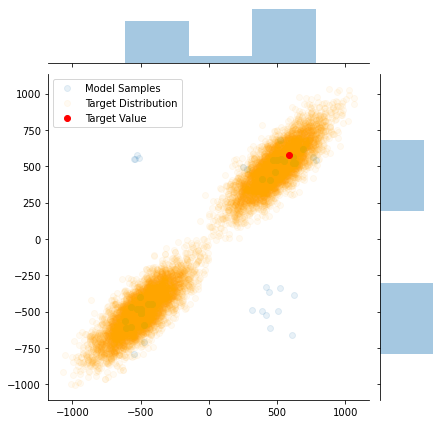

In [562]:
i = 55
estimator = RandomForestRegressor(n_estimators = 10,min_samples_leaf = 2)
density_estimator = NaiveTreeEnsemble(estimator).fit(X_train,y_train)

samples = density_estimator.sample(X_test[i:i+1], sample_size = 700)

jntplot = sns.jointplot(samples[0,:,0], samples[0,:,1], joint_kws = {'label':'Model Samples', 'alpha':0.1})
jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.05, label = 'Target Distribution')
jntplot.ax_joint.scatter(y_test[i,0], y_test[i,1], color = 'red', label = 'Target Value')

jntplot.ax_joint.legend()

## ForestSimilarityEstimator - 

Estimates the conditional distribution based on samples from dataset taking into account the `leaf_sample_graph`

In [563]:
#export
def SimilarityTreeEnsemble(estimator):    
    
    class SimilarityTreeEnsemble(estimator.__class__, EnsembleTreesDensityMixin):
        
        def __init__(self, alpha = 1, n_neighbors = 30, lower_bound = 0.0):            
            super().__init__(**estimator.get_params())     
            self.n_neighbors = n_neighbors
            self.lower_bound = lower_bound
            self.alpha = alpha
            
        def __repr__(self):
            return self.__class__.__name__
            
        def fit(self, X, y = None):        
            super().fit(X,y)        
            self._fit_leaf_sample_graph(X)
            self.y_ = y
            return self
    
        def sample(self, X, sample_size = 10, weights = None, n_neighbors = None, lower_bound = None, alpha = None):
            '''wieghts should be callable (recieves array returns array of same shape) or None'''
            n_neighbors, lower_bound, alpha = self._handle_similarity_sample_parameters(n_neighbors, lower_bound, alpha)
                
            return super()._similarity_sample(
                X = X, sample_size = sample_size, weights = weights, n_neighbors = n_neighbors,
                lower_bound = lower_bound, alpha = alpha
            )
        
        def sim_predict(self, X, weights = None, n_neighbors = None, lower_bound = None, alpha = None):
            n_neighbors, lower_bound, alpha = self._handle_similarity_sample_parameters(n_neighbors, lower_bound, alpha)
            return self._sim_predict(X, weights, n_neighbors, lower_bound, alpha)
        
        def _handle_similarity_sample_parameters(self, n_neighbors, lower_bound, alpha):
            
            if n_neighbors is None:
                n_neighbors = self.n_neighbors
            if lower_bound is None:
                lower_bound = self.lower_bound
            if alpha is None:
                alpha = self.alpha
            
            return n_neighbors, lower_bound, alpha
       
    return SimilarityTreeEnsemble()

We can see that forest estimators are better in dealing with bimodal data

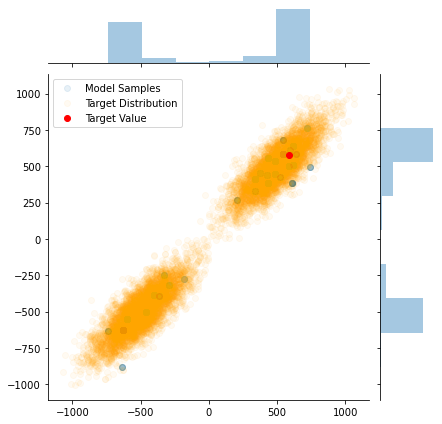

In [564]:
i = 55
estimator = RandomForestRegressor(n_estimators = 10,min_samples_leaf = 2)
density_estimator = SimilarityTreeEnsemble(estimator).fit(X_train,y_train)

samples = density_estimator.sample(X_test[i:i+1], sample_size = 700, alpha = 5)

jntplot = sns.jointplot(samples[0,:,0], samples[0,:,1], joint_kws = {'label':'Model Samples', 'alpha':0.1})
jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.05, label = 'Target Distribution')
jntplot.ax_joint.scatter(y_test[i,0], y_test[i,1], color = 'red', label = 'Target Value')

jntplot.ax_joint.legend()

# Meta Estimators (Bagging, Boosting, Stacking)

## BaggingDensityEstimator

In [620]:
#export
def _parallel_predict_regression(estimators, estimators_features, X):
    """Private function used to compute predictions within a job."""
    return np.array([estimator.predict(X[:, features])
               for estimator, features in zip(estimators,
                                              estimators_features)])

class BaggingDensityEstimator(ensemble.BaggingRegressor):
    
    def sample(self, X, sample_size = 10, weights = None):
        idxs = self._sample_idxs(X, sample_size, weights)
        predictions = self._predict_all_estimators(X)
        return self._sample_from_idxs(predictions, idxs)        
        
    def _predict_all_estimators(self, X):    
        ensemble._bagging.check_is_fitted(self)
        # Check data
        X = ensemble._bagging.check_array(
            X, accept_sparse=['csr', 'csc'], dtype=None,
            force_all_finite=False
        )

        # Parallel loop
        n_jobs, n_estimators, starts = ensemble._bagging._partition_estimators(self.n_estimators,
                                                             self.n_jobs)

        all_y_hat = ensemble._bagging.Parallel(n_jobs=n_jobs, verbose=self.verbose)(
            ensemble._bagging.delayed(_parallel_predict_regression)(
                self.estimators_[starts[i]:starts[i + 1]],
                self.estimators_features_[starts[i]:starts[i + 1]],
                X)
            for i in range(n_jobs))

        predictions = np.swapaxes(all_y_hat[0], 0, 1)
        return predictions
    
    def _sample_from_idxs(self, predictions, idxs):        
        return np.array([predictions[i][idxs[i]] for i in range(len(idxs))])
    
    def _sample_idxs(self, X, sample_size, weights):
        '''Sample indxs according to estimator weights'''
        return [np.random.choice([*range(self.n_estimators)], size = sample_size, p = weights) for i in range(X.shape[0])]
            

The BaggingDensityEstimator is an extension of sklearn BaggingRegressor that allows sampling from each isntance of base estimator. We can bag Linear Regressors for example

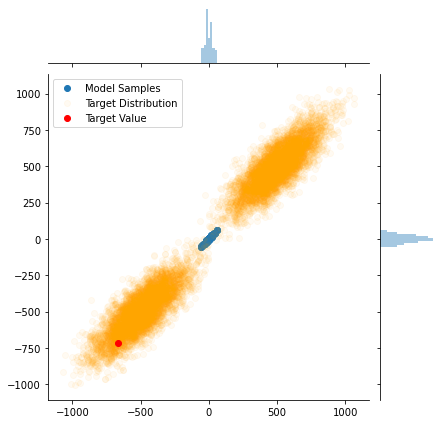

In [621]:
from sklearn.linear_model import LinearRegression
estimator = LinearRegression()
density_estimator = BaggingDensityEstimator(estimator, n_estimators = 100, max_samples = 0.2, max_features = 0.2).fit(X,y)

samples = density_estimator.sample(X_test[0:1], sample_size = 100)

jntplot = sns.jointplot(samples[0,:,0], samples[0,:,1], joint_kws = {'label':'Model Samples'})
jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.05, label = 'Target Distribution')
jntplot.ax_joint.scatter(y_test[0,0], y_test[0,1], color = 'red', label = 'Target Value')

jntplot.ax_joint.legend()

We can combine with the TransformedTargetEstimator to transform the output space before regression

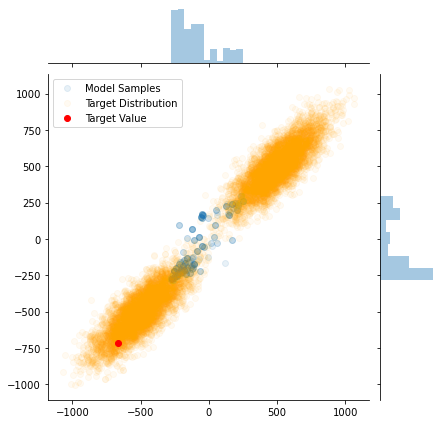

In [622]:
estimator = TransformedTargetEstimator(LinearRegression)()
density_estiamtor = BaggingDensityEstimator(estimator, n_estimators = 100, max_samples = 0.3,max_features = 0.3).fit(X,y)

samples = density_estiamtor.sample(X_test[0:1], sample_size = 300)

jntplot = sns.jointplot(samples[0,:,0], samples[0,:,1], joint_kws = {'label':'Model Samples', 'alpha':0.1})
jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.05, label = 'Target Distribution')
jntplot.ax_joint.scatter(y_test[0,0], y_test[0,1], color = 'red', label = 'Target Value')

jntplot.ax_joint.legend()

## AdaBoostDensityEstimator

In [623]:
#export
class AdaBoostDensityEstiamtor(ensemble.AdaBoostRegressor):
    
    def sample(self, X, sample_size = 10, weights = 'boosting_weights'):
        idxs = self._sample_idxs(X, sample_size, weights)
        predictions = self._predict_all_estimators(X)
        return self._sample_from_idxs(predictions, idxs)
    
    def _predict_all_estimators(self, X):    
        return np.array([est.predict(X) for est in self.estimators_[:len(self.estimators_)]]).T
    
    def _sample_from_idxs(self, predictions, idxs):
        return np.array([predictions[i][idxs[i]] for i in range(len(idxs))])
    
    def _sample_idxs(self, X, sample_size, weights):
        '''Sample indxs according to estimator weights'''        
                        
        if weights is None:
            weights = np.ones(sample_size)[:len(self.estimators_)]
            weights /= weights.sum()
            
        elif weights == 'boosting_weights':
            weights = self.estimator_weights_[:len(self.estimators_)]
            weights /= weights.sum()            
        else:
            weights = self.estimator_weights_[:len(self.estimators_)]*weights
            weights /= weights.sum()        
            
        idxs = [np.random.choice([*range(len(self.estimators_))], size = sample_size, p = weights) for i in range(X.shape[0])]
        return idxs
        
        

AdaBoostDensityEstimator suports only single output tasks. you can use CustomMultiOutputRegressor, but since it will fit each output dimension separetly, you have a decent prediction for the marginal distributions but not for the joint distribution.

For this reason, AdaBoostEstimator is not recomended for multivariate density estimation

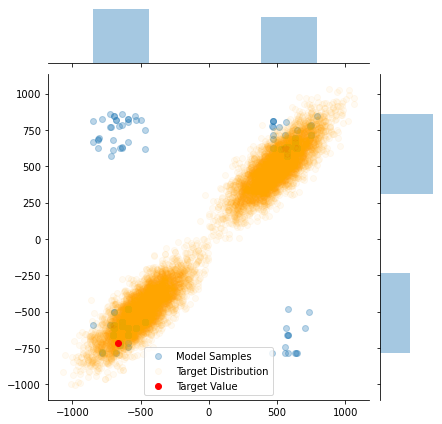

In [635]:
from sklearn.tree import DecisionTreeRegressor
estimator = AdaBoostDensityEstiamtor(TransformedTargetEstimator(DecisionTreeRegressor)(), learning_rate = 0.01)
multioutput_estimator = CustomMultiOutputRegressor(estimator)
density_estimator = multioutput_estimator.fit(X_train, y_train)

samples = density_estimator.sample(X_test[0:1], sample_size = 100)

jntplot = sns.jointplot(samples[0,:,0], samples[0,:,1], joint_kws = {'label':'Model Samples', 'alpha':0.3})
jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.05, label = 'Target Distribution')
jntplot.ax_joint.scatter(y_test[0,0], y_test[0,1], color = 'red', label = 'Target Value')

jntplot.ax_joint.legend()

We can see that for 1d estimation it works quite well

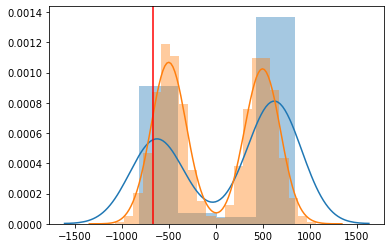

In [639]:
import matplotlib.pyplot as plt
estimator = DecisionTreeRegressor()
density_estimator = AdaBoostDensityEstiamtor(estimator, learning_rate = 0.1).fit(X_train, y_train[:,0])

samples = density_estimator.sample(X_test[0:1], sample_size = 100)

sns.distplot(samples)
sns.distplot(y_train[:,0])
plt.axvline(y_test[0,0], color = 'r')


## StackingDensityEstimator
> Allows for stacking while making the input of last layer as a sample of last estimators samples

In [ ]:
#hide
#not going to implement it for now. must check if implementation has some use
from functools import partial

AVALIBLE_STACKING_METHODS = {
    'pdf_sample':'_fit_sample_pdf',
    'pdf_params':'_fit_getparams_pdf',
    'empirical_sample':'_empirical_sample'
}
        

# pass stacking method
def StackingChildFactory(estimator, stack_method = 'empirical_sample', stack_method_kwargs = dict(dist = None, sample_size = 10)):
    
    class StackingChildEstimator(estimator.__class__):
        
        def __init__(self, stack_method,  stacking_method_kwargs = {'sample_size':30, 'weights':None}):            
            super().__init__(**estimator.get_params())
            self.stacking_method_kwargs = stacking_method_kwargs
            self.stack_method = self._handle_stack_method(stack_method)
        
        def _handle_stack_method(self, stack_method, **method_kwargs):
            if not stack_method.__class__ == str:
                raise ValueError(f'stack_method should be a str of the stacking_method name, got {stack_method.__class__.__name__} instead')
            if not hasattr(self, stack_method):
                raise ValueError(f'stack_method should be a str of the stacking_method name. {self} has no attribute {stack_method}')            
            return stack_method
        
        def _apply_stacking_method(self, stacking_method, X, sample_size = 30, weights = None):
            
            '''
            A method that recieves X as input and returns the "y" values that will be passed to
            the next layer.
            custom methods are applied to sampled values from estimator
            '''
            
            getattr(self, stacking_method)()
            return y
        
        def pdf_sample(self, X, dist = 'norm', sample_size = 10, empirical_sample_args = {}):
            
            data = self.sample(X, **empirical_sample_args)
            pdf = RandomVariable(data).fit_dist(dist)
        
        return pdf.rvs(sample_size).data

        def pdf_params(self, data, dist, sample_size):
            pdf = RandomVariable(data).fit_dist(dist)
            return pdf.params.data.flatten()

        def empirical_sample(self, data, dist, sample_size):
            '''dist here are the sample weights'''
            dist /= dist.sum()
            return np.random.choice(data, size = sample_size, p = dist)
        
    return StackingChildEstimator
        
        
def StackingDensityEstimator(stack_method = 'empirical_sample', stack_method_kwargs = dict(dist = None, sample_size = 10)):
    
    stack_method_name = stack_method
    
    class StackingDensityEstimator(ensemble.StackingRegressor):
        
        def _handle_stack_method(self, stack_method, **method_kwargs):
            if stack_method.__class__ == str:
                return partial(AVALIBLE_STACKING_METHODS[stack_method], **method_kwargs)
            else:
                return partial(stack_method, **method_kwargs)

        def fit(self, X, y = None):
            
            stack_method = self._handle_stack_method(stack_method_name,**stack_method_kwargs)
            for est in self.estimators:
                setattr(est[1], '_default_stacking_method', stack_method)
                print(est[1]._default_stacking_methods)
            self.stack_method = '_default_stacking_method'
            super().fit(X,y)
            return self 
    
    return StackingDensityEstimator

class StackingDensityEstimator(ensemble.StackingRegressor):
    def _sample_from_child(self,X):
        '''
        Instead of recieving the prediction of last estimator, it recieves a sumsample of each one of last estimators.
        child estimators contaion a sample method        
        '''
        pass
    
    def  _concatenate_children_output(self, outputs): 
        '''
        Concatenates the children samples 
        '''
        pass
    
    def _set_prior_to_sample():
        '''
        Instead of sampling from data, fit a disstribution  through MLE to data and sample from prior distribution.
        Like in variational auto encoders.
        '''
        pass
    
    def _pass_dist_parameters_instead_of_samples():
        '''
        instead of passing samples to next layer, pass distribution parameters found through MLE
        '''
        pass
    def _apply_method(X):
        '''
        Applies a generic method in the output stacking layer taking X from the stacking pipeline as argument.
        allows sample method and apply method for trees
        '''
        pass
    
    #NO NEED FOR SAMPLE METHOD SINCE IT WILL IMPLEMENT THE LAST LAYYER METHODS

In [ ]:
t = StackingDensityEstimator()
e1 = BaggingDensityEstimator(TransformedTargetEstimator(LinearRegression)(), n_estimators = 10, max_samples = 0.2,max_features = 0.2).fit(X,y)
e2 = BaggingDensityEstimator(LinearRegression(), n_estimators = 10).fit(X,y)

t([('e1',e1),('e2',e2)],e1).fit(X_train,y_train[:,1])

In [571]:
#from sklearn import ensemble
ens = ensemble.StackingRegressor(('l1',RandomForestRegressor()), RandomForestRegressor())

In [572]:
ens.fit(X_train, y_train)

ValueError: y should be a 1d array, got an array of shape (8000, 2) instead.